In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

In [2]:
sorted_concatenated_csv = "../neural-agent-models/data/simulation data/100x100.csv"
data = pd.read_csv(sorted_concatenated_csv)
#data.drop(columns=['zCOM'], inplace=True)
print(data.head())
data['time'] = (data['mcsteps'] / 10000).astype(int)
data = data[['time'] + [col for col in data.columns if col != 'time']]
data.drop(columns=['mcsteps'], inplace=True)
print(data)
# define cytokines
cytokines = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

# Remove brackets and convert to float
for col in cytokines:
    data[col] = data[col].str.strip('[]').astype(float)

   mcsteps  xCOM  yCOM              il8   il1   il6  il10   tnf   tgf
0        0    78    62   [8.155469e-08]  [0.]  [0.]  [0.]  [0.]  [0.]
1        0    29    17   [3.716848e-09]  [0.]  [0.]  [0.]  [0.]  [0.]
2        0    64    24  [3.4276149e-09]  [0.]  [0.]  [0.]  [0.]  [0.]
3        0    77    16  [3.7302027e-13]  [0.]  [0.]  [0.]  [0.]  [0.]
4        0    29     7  [3.9552712e-16]  [0.]  [0.]  [0.]  [0.]  [0.]
       time  xCOM  yCOM              il8              il1              il6  \
0         0    78    62   [8.155469e-08]             [0.]             [0.]   
1         0    29    17   [3.716848e-09]             [0.]             [0.]   
2         0    64    24  [3.4276149e-09]             [0.]             [0.]   
3         0    77    16  [3.7302027e-13]             [0.]             [0.]   
4         0    29     7  [3.9552712e-16]             [0.]             [0.]   
...     ...   ...   ...              ...              ...              ...   
33842   100    97    49  [1.413103

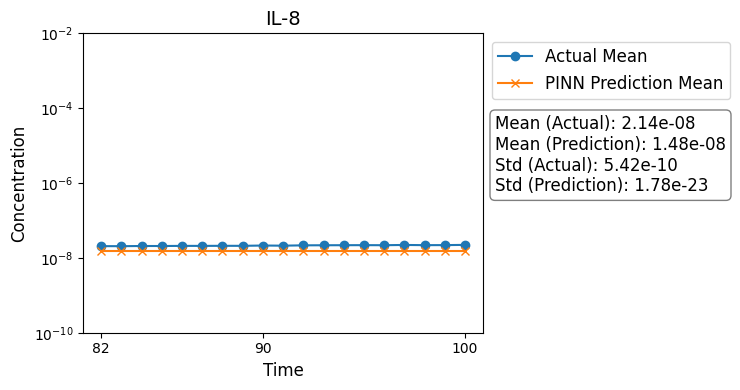

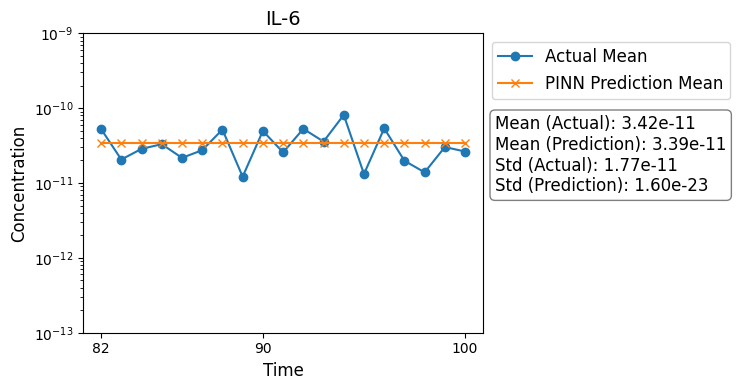

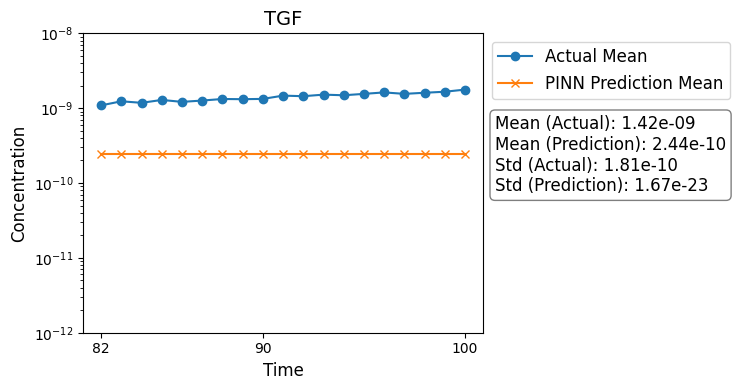

In [5]:
predictions_path = '../PINN(100x100)(82-100hrs).csv'
predictions = pd.read_csv(predictions_path)

predictions.columns = ['time', 'xCOM', 'yCOM', 'il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']


predictions['time'] = predictions['time'].map(lambda t: t + 82 if 0 <= t <= 19 else t)

filtered_data = data[(data['time'] >= 82) & (data['time'] <= 100)]


time_steps = np.arange(82, 101)
x_range = np.arange(0, 100)
y_range = np.arange(0, 100)
features = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

y_pred = np.zeros((19, 100, 100, 6))
y_test = np.zeros((19, 100, 100, 6))

for t in time_steps:
    t_idx = t - 82
    pred_t = predictions[predictions['time'] == t]
    actual_t = filtered_data[filtered_data['time'] == t]
    for _, row in pred_t.iterrows():
        x, y = int(row['xCOM']), int(row['yCOM'])
        y_pred[t_idx, x, y, :] = row[features].values
    for _, row in actual_t.iterrows():
        x, y = int(row['xCOM']), int(row['yCOM'])
        y_test[t_idx, x, y, :] = row[features].values


combined_data = np.concatenate([y_test, y_pred])

output_dir = 'plots-PINN'
os.makedirs(output_dir, exist_ok=True)

masked_data = np.ma.masked_equal(combined_data, 0)
lower_limit = 1e-12
upper_limit = 1e-7

min_values = np.ma.min(masked_data, axis=(0, 1, 2))
max_values = np.ma.max(masked_data, axis=(0, 1, 2))

min_values = min_values.filled(np.nan)
max_values = max_values.filled(np.nan)

y_test_avg = np.mean(y_test, axis=(1, 2))
y_pred_avg = np.mean(y_pred, axis=(1, 2))

y_test_mean = np.mean(y_test_avg, axis=0)
y_pred_mean = np.mean(y_pred_avg, axis=0)
y_test_std = np.std(y_test_avg, axis=0)
y_pred_std = np.std(y_pred_avg, axis=0)

time_steps = np.arange(82, 101)
selected_time_steps = [82, 90, 100]

labels_to_plot = ['IL-8', 'IL-6', 'TGF']
indices_to_plot = [0, 2, 5] 
custom_limits = [(1e-10, 1e-2), (1e-13, 1e-9), (1e-12, 1e-8)]

for i, label, (lower, upper) in zip(indices_to_plot, labels_to_plot, custom_limits):
    plt.figure(figsize=(10, 4))
    plt.plot(time_steps, y_test_avg[:, i], label='Actual Mean', marker='o')
    plt.plot(time_steps, y_pred_avg[:, i], label='PINN Prediction Mean', marker='x')

    plt.ylabel('Concentration', fontsize=12)
    plt.yscale('log')
    plt.ylim(lower, upper)
    
    plt.xticks(selected_time_steps)
    

    textstr = '\n'.join((
        f'Mean (Actual): {y_test_mean[i]:.2e}',
        f'Mean (Prediction): {y_pred_mean[i]:.2e}',
        f'Std (Actual): {y_test_std[i]:.2e}',
        f'Std (Prediction): {y_pred_std[i]:.2e}',
    ))
    plt.gcf().text(0.5, 0.7, textstr, fontsize=12,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    plt.xlabel('Time', fontsize=12)
    plt.title(label, fontsize=14)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    

    plot_filename = f'{label}_concentrations_time_series.png'
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path, bbox_inches='tight')
    plt.show()

**Correlation Plot**

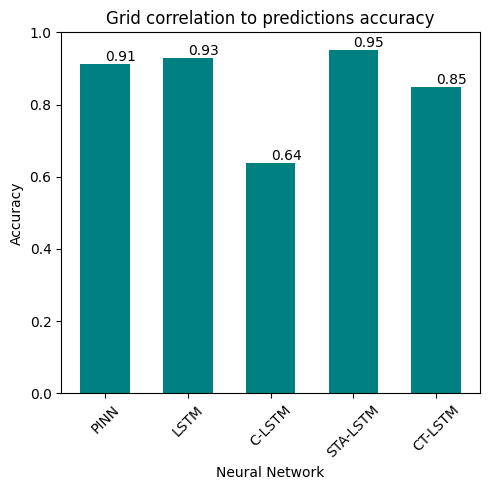

In [6]:
data = {
    'Model': ['PINN', 'LSTM', 'C-LSTM', 'STA-LSTM', 'CT-LSTM'],
    '50x50': [0.9276, 0.9361, 0.8886, 0.9453, 0.9539],
    '100x100': [0.8949, 0.9199, 0.5528, 0.9682, 0.8186],
    '250x250': [0.9168, 0.9306, 0.4738, 0.9357, 0.7768],
    #'500x500': [0.9349, 0, 0, 0.9243, 0]
}

df = pd.DataFrame(data)
df.set_index('Model', inplace=True)

df['Average'] = df.mean(axis=1)

bar_width = 0.6
positions = np.arange(len(df.index))

plt.figure(figsize=(5, 5))
bars = plt.bar(positions, df['Average'], color='teal', width=bar_width)

plt.xlabel('Neural Network')
plt.ylabel('Accuracy')
plt.title('Grid correlation to predictions accuracy')
plt.xticks(positions, df.index, rotation=45)
plt.ylim(0, 1)
plt.tight_layout()

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom')
plt.show()


*Timeseries Merged*

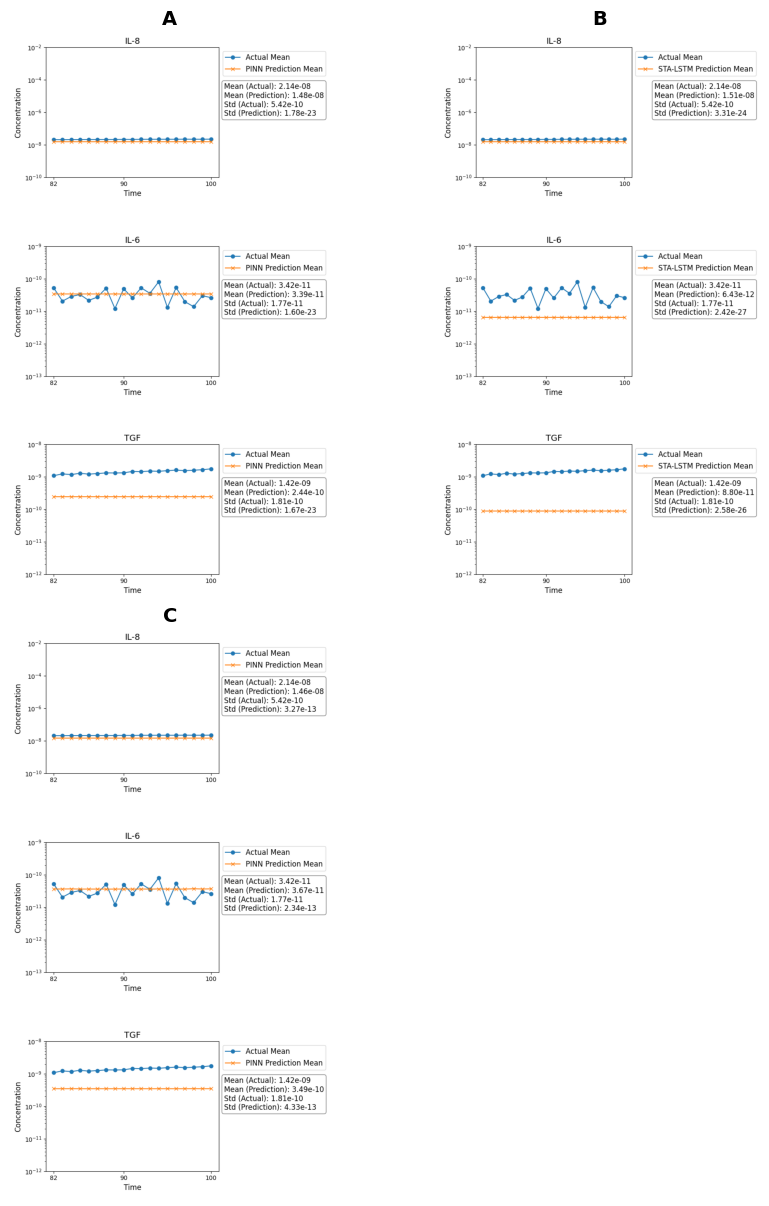

In [9]:
# Create a figure with a custom GridSpec layout
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(6, 2, figure=fig)

# List of file paths for the images
image_files = [
    'C:/Users/Giannis/Desktop/C il8.png',
    'C:/Users/Giannis/Desktop/STA il8.png',
    'C:/Users/Giannis/Desktop/PINN il8.png',
    'C:/Users/Giannis/Desktop/C il6.png',
    'C:/Users/Giannis/Desktop/STA il6.png',
    'C:/Users/Giannis/Desktop/PINN il6.png',
    'C:/Users/Giannis/Desktop/C tgf.png',
    'C:/Users/Giannis/Desktop/STA tgf.png',
    'C:/Users/Giannis/Desktop/PINN tgf.png',
]

# Define the grid layout
positions = [
    (0, 0), (0, 1), (3, 0),  # First column: C images
    (1, 0), (1, 1), (4, 0), 
    (2, 0), (2, 1), (5, 0),
]

# Load and display each image in the appropriate subplot
labels = ['A', 'B', 'C']
il8_indices = [0, 1, 2]  # Indices of IL8 plots for each category

# Load and display each image in the appropriate subplot
for i, (file, pos) in enumerate(zip(image_files, positions)):
    ax = fig.add_subplot(gs[pos])
    img = mpimg.imread(file)
    ax.imshow(img)
    ax.axis('off')  # Hide axes


    if i in il8_indices:
        label_index = il8_indices.index(i)
        ax.set_title(labels[label_index], fontsize=14, fontweight='bold', color='black')

# Adjust layout with smaller gaps
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)
plt.show()
